<a href="https://colab.research.google.com/github/VJsai45/English-to-Hindi-Transliteration/blob/main/English_to_Hindi_Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import array
from numpy import argmax
from numpy import array_equal
from random import randint
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


In [ ]:
# !wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
# # Download Dakshina dataset

In [ ]:
# !tar -xvf 'dakshina_dataset_v1.0.tar' -C '/content/drive/MyDrive/Quick Data/Dakshina Dataset'
# # untar and store data

In [ ]:
all_hindi_eng_data = pd.read_csv('/content/drive/MyDrive/Quick Data/Dakshina Dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv',names=['all'])
# read data into dataframe

In [ ]:
all_hindi_eng_data

,all
0,अं\tan\t3
1,अंकगणित\tankganit\t3
2,अंकल\tuncle\t4
3,अंकुर\tankur\t4
4,अंकुरण\tankuran\t3
...,...
44199,ह्वेनसांग\thiuentsang\t1
44200,ह्वेनसांग\thsuantsang\t1
44201,ह्वेनसांग\thyensang\t1
44202,ह्वेनसांग\txuanzang\t1


In [ ]:
split_data = all_hindi_eng_data["all"].str.split("\t",n=2,expand=True)
# split the eng words, hindi words and length data
split_data

,0,1,2
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3
...,...,...,...
44199,ह्वेनसांग,hiuentsang,1
44200,ह्वेनसांग,hsuantsang,1
44201,ह्वेनसांग,hyensang,1
44202,ह्वेनसांग,xuanzang,1


In [ ]:
X_train_english = split_data[1]
y_train_hindi = split_data[0]
X_train_english, y_train_hindi
# read them into series

(0                an
 1          ankganit
 2             uncle
 3             ankur
 4           ankuran
             ...    
 44199    hiuentsang
 44200    hsuantsang
 44201      hyensang
 44202      xuanzang
 44203            om
 Name: 1, Length: 44204, dtype: object, 0               अं
 1          अंकगणित
 2             अंकल
 3            अंकुर
 4           अंकुरण
            ...    
 44199    ह्वेनसांग
 44200    ह्वेनसांग
 44201    ह्वेनसांग
 44202    ह्वेनसांग
 44203            ॐ
 Name: 0, Length: 44204, dtype: object)

In [ ]:
X_train_english_array = np.array(X_train_english)
X_train_english_array
y_train_hindi_array = np.array(y_train_hindi)
y_train_hindi_array
# convert to arrays

array(['अं', 'अंकगणित', 'अंकल', ..., 'ह्वेनसांग', 'ह्वेनसांग', 'ॐ'],
      dtype=object)

In [ ]:
X_train_english_chars = X_train_english.apply(lambda x: list(x)) 

In [ ]:
X_train_english_chars.head()

0                      [a, n]
1    [a, n, k, g, a, n, i, t]
2             [u, n, c, l, e]
3             [a, n, k, u, r]
4       [a, n, k, u, r, a, n]
Name: 1, dtype: object

In [ ]:
y_train_hindi_chars = y_train_hindi.apply(lambda x: list(x))

In [ ]:
y_train_hindi_chars.head()

0                   [अ, ं]
1    [अ, ं, क, ग, ण, ि, त]
2             [अ, ं, क, ल]
3          [अ, ं, क, ु, र]
4       [अ, ं, क, ु, र, ण]
Name: 0, dtype: object

In [ ]:
input_words = X_train_english_array.copy()
target_words = pd.Series([y+'>' for y in y_train_hindi_array]) # add start token in target words
target_shifted_words = pd.Series(['<'+y for y in y_train_hindi_array]) # add end token in shifted target words(decoder input)


In [ ]:
target_words.head()

0         अं>
1    अंकगणित>
2       अंकल>
3      अंकुर>
4     अंकुरण>
dtype: object

In [ ]:
target_shifted_words.head()

0         <अं
1    <अंकगणित
2       <अंकल
3      <अंकुर
4     <अंकुरण
dtype: object

In [ ]:
eng_chars = [""]
for word in input_words:
  for char in word:
    if char not in eng_chars:
      eng_chars.append(char)
eng_chars = sorted(eng_chars)
# create english characters dictionary

In [ ]:
hindi_chars = ["",'<','>']
for word in target_words:
  for char in word:
    if char not in hindi_chars:
      hindi_chars.append(char)
hindi_chars = sorted(hindi_chars)
# create hindi characters dictionary

In [ ]:
no_of_encoder_tokens = len(eng_chars)
no_of_decoder_tokens = len(hindi_chars)
max_encoder_sequence_length = max([len(word) for word in input_words])
max_decoder_sequence_length = max([len(word) for word in target_words])
# calculate number of encoder/decoder token and max encoder/deocder word length

In [ ]:
no_of_encoder_tokens, no_of_decoder_tokens, max_encoder_sequence_length, max_decoder_sequence_length

(27, 66, 20, 20)

In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(eng_chars)])
target_token_index = dict([(char, i) for i, char in enumerate(hindi_chars)])
# create input and target character dictionaries

In [ ]:
reverse_input_token_index = dict([(i, char) for i, char in enumerate(eng_chars)])
reverse_output_token_index = dict([(i, char) for i, char in enumerate(hindi_chars)])
# create reverse input and target character dictionaries while decoding

In [ ]:
encoder_input_data = np.zeros((len(input_words),max_encoder_sequence_length,no_of_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(target_shifted_words),max_decoder_sequence_length,no_of_decoder_tokens),dtype='float32')
decoder_output_data = np.zeros((len(target_words),max_decoder_sequence_length,no_of_decoder_tokens),dtype='float32')
# create encoder/decoder input/data arrays

In [ ]:
encoder_input_data.shape, decoder_input_data.shape, decoder_output_data.shape

((44204, 20, 27), (44204, 20, 66), (44204, 20, 66))

In [ ]:
for i,(input_word,target_shifted_word,target_word) in enumerate(zip(input_words,target_shifted_words,target_words)):
  for t,char in enumerate(input_word):
    encoder_input_data[i,t,input_token_index[char]] = 1.0 
  encoder_input_data[i,t+1:,input_token_index[""]] = 1.0 # for padding remaing characters with empty space " "

  for t,char in enumerate(target_shifted_word):
    decoder_input_data[i,t,target_token_index[char]] = 1.0
  decoder_input_data[i,t+1:,target_token_index[""]] = 1.0 # for padding remaing characters with empty space " "

  for t,char in enumerate(target_word):
    decoder_output_data[i,t,target_token_index[char]] = 1.0
  decoder_output_data[i,t+1:,target_token_index[""]] = 1.0 # for padding remaing characters with empty space " "


# one hot encode the data and fill up the arrays

In [ ]:
word = ''
for c in np.argmax(encoder_input_data[432,:,:], axis=1):
  word+=reverse_input_token_index[c]
word

'ajnabiyon'

In [ ]:
word = ''
for c in np.argmax(decoder_input_data[432,:,:], axis=1):
  word+=reverse_output_token_index[c]
word

'<अजनबियों'

In [ ]:
word = ''
for c in np.argmax(decoder_output_data[432,:,:], axis=1):
  word+=reverse_output_token_index[c]
word

'अजनबियों>'

In [ ]:
# returns training model
def define_models(n_input, n_output, n_units,no_of_layers):
  # define training encoder
  encoder_inputs = Input(shape=(None, n_input))
  input_to_encoder = encoder_inputs
  encoder_states = []

  for l in range(no_of_layers):
    if l == no_of_layers-1:
      encoder = LSTM(n_units, return_sequences=False, return_state=True,name='encoder'+str(l+1))
      _, state_h, state_c = encoder(input_to_encoder)
    else:
      encoder = LSTM(n_units, return_sequences=True, return_state=True,name='encoder'+str(l+1))
      encoder_outputs, state_h, state_c = encoder(input_to_encoder)
    encoder_states.extend([state_h, state_c])
    input_to_encoder = [encoder_outputs] 

	# define training decoder
  decoder_inputs = Input(shape=(None, n_output))
  input_to_decoder = decoder_inputs
  decoder_states_initial = encoder_states
  print("encoder states", encoder_states)

  for l in range(no_of_layers):
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True,name='deocder'+str(l+1))
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(input_to_decoder, initial_state=decoder_states_initial[(2*l):(2*l)+2])
    input_to_decoder = decoder_outputs


  decoder_dense = tf.keras.layers.TimeDistributed(Dense(n_output, activation='softmax', name='softmax'))
  dropout_op = Dropout(0.5)(input_to_decoder)
  decoder_outputs = decoder_dense(dropout_op)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  return model


In [ ]:
latent_dimensions = 1024

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, 
                                               restore_best_weights=False,
                                                 monitor='val_loss')

checkpoint_path = "/content/drive/MyDrive/Quick Data/English Hindi Transliteration/cp-2-layer-{epoch:01d}-{val_accuracy:03f}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(encoder_input_data) * 30
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)


class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()


## Running Models

In [ ]:
training_model = define_models(no_of_encoder_tokens, no_of_decoder_tokens, latent_dimensions, 2)

encoder states [<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'encoder1')>, <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'encoder1')>, <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'encoder2')>, <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'encoder2')>]


In [ ]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 27)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 66)]   0           []                               
                                                                                                  
 encoder1 (LSTM)                [(None, None, 1024)  4308992     ['input_1[0][0]']                
                                , (None, 1024),                                                   
                                 (None, 1024)]                                                    
                                                                                              

In [ ]:
training_model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
training_model.load_weights('/content/drive/MyDrive/Quick Data/English Hindi Transliteration/cp-2-layer-9-0.865886.ckpt')

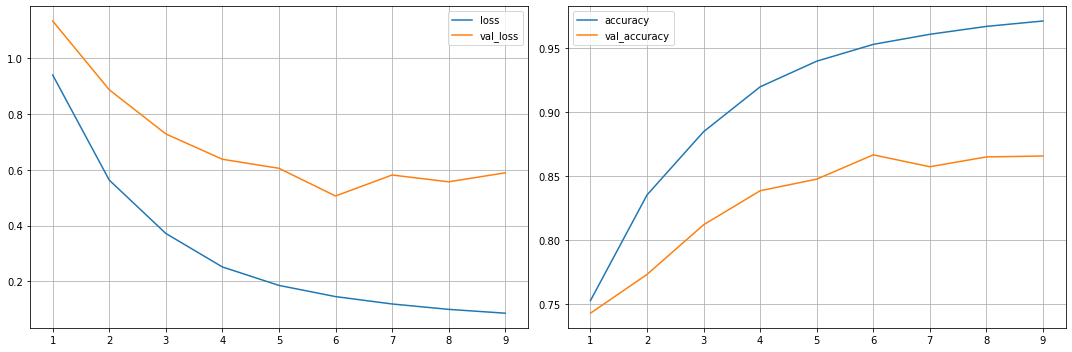

553/553 [==============================] - 45s 81ms/step - loss: 0.0865 - accuracy: 0.9714 - val_loss: 0.5888 - val_accuracy: 0.8659


In [ ]:
  training_model.fit([encoder_input_data,decoder_input_data],decoder_output_data,
    batch_size=64,
    epochs=30,
    validation_split=0.2,
    callbacks=[cp_callback,PlotLearning(), early_stopping])

In [ ]:
no_of_layers = 2

In [ ]:
encoder_inputs = training_model.input[0]
encoder_states = [] 
for l in range(no_of_layers):
  encoder_outputs, state_h, state_c = training_model.layers[((2*l)+2)].output
  encoder_states+= [state_h, state_c]
encoder_model = tf.keras.Model(encoder_inputs, [encoder_outputs,encoder_states])

# define inference decoder
decoder_inputs = training_model.input[1]  # input_2
decoder_states_initial = []
for l in range(no_of_layers):
  decoder_state_input_h = Input(shape=(latent_dimensions,))
  decoder_state_input_c = Input(shape=(latent_dimensions,))
  decoder_states_initial.extend([decoder_state_input_h, decoder_state_input_c])

decoder_inputs_infer = decoder_inputs
decoder_states = []
for l in range(no_of_layers):
  decoder_outputs, state_h, state_c = training_model.layers[((2*l)+1)+2](decoder_inputs_infer, initial_state=decoder_states_initial[(2*l):(2*l)+2])
  decoder_states.extend([state_h, state_c])
  decoder_inputs_infer = decoder_outputs
decoder_outputs = training_model.layers[((2*no_of_layers)+3)](decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_initial, [decoder_outputs] + decoder_states)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 27)]        0         
                                                                 
 encoder1 (LSTM)             [(None, None, 1024),      4308992   
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
 encoder2 (LSTM)             [(None, 1024),            8392704   
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
Total params: 12,701,696
Trainable params: 12,701,696
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 66)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 deocder1 (LSTM)                [(None, None, 1024)  4468736     ['input_2[0][0]',                
                                , (None, 1024),                   'input_3[0][0]',          

In [ ]:
def predict_word(input):
  one_hot_input = np.zeros((1,max_encoder_sequence_length,no_of_encoder_tokens),dtype="float32")
  for i,char in enumerate(input):
    one_hot_input[0,i,input_token_index[char]] = 1.0
  one_hot_input[0,i+1:,input_token_index[""]] = 1.0
  word = ''
  for c in np.argmax(one_hot_input[0,:,:], axis=1):
    word+=reverse_input_token_index[c]
  encoder_outputs, encoder_output_state = encoder_model.predict(one_hot_input, verbose=0)
  # encode the input
  start_token = np.zeros((1,1,no_of_decoder_tokens),dtype="float32")
  # create the start token for decoder
  start_token[0,0,target_token_index['<']] = 1.0
  decoded_word = ""
  decoded_char = ''
  decoder_states = encoder_output_state
  decoder_input = start_token
  count = 0
  stop = False
  i=0
  while not stop:
    # copy the encoder op state to decoder state
    decoder_output,dh1,dc1,dh2,dc2 = decoder_model.predict(
       [decoder_input] + decoder_states , verbose=0
    )
    # pass the start token and states to decoder
    decoded_char_index = np.argmax(decoder_output[0,0,:])
    decoded_char = reverse_output_token_index[decoded_char_index]
    decoded_word += decoded_char
    # deocde the char and append to the word
    decoder_input = np.zeros((1,1,no_of_decoder_tokens),dtype="float32")
    decoder_input[0,0,target_token_index[decoded_char]] = 1.0
    i+=1
    # update the decoder input
    decoder_states = [dh1,dc1,dh2,dc2]
    count = count + 1
    if (decoded_char == '>' ):
      stop = True
      decoded_word = decoded_word[:-1]
    elif count > 20:
      stop = True
    # update the decoder states
  return decoded_word


In [ ]:
predict_word("tropical")

'ट्रॉपिकल'

In [ ]:
validation_hindi_eng_data = pd.read_csv('/content/drive/MyDrive/Quick Data/Dakshina Dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv',names=['all'])


In [ ]:
validation_hindi_eng_data.head()

,all
0,अंकन\tankan\t3
1,अंगकोर\tangkor\t3
2,अंगिरा\tangira\t3
3,अंगीठी\tangithi\t3
4,अंग्रेज\tangrej\t3


In [ ]:
split_data = validation_hindi_eng_data["all"].str.split("\t",n=2,expand=True)
# split the eng words, hindi words and length data
split_data

,0,1,2
0,अंकन,ankan,3
1,अंगकोर,angkor,3
2,अंगिरा,angira,3
3,अंगीठी,angithi,3
4,अंग्रेज,angrej,3
...,...,...,...
4353,होल्डर,holder,3
4354,होशो,hosho,3
4355,ह्यूअर,huar,1
4356,ह्यूअर,hyuar,1


In [ ]:
X_valid_english = split_data[1]
y_valid_hindi = split_data[0]
X_valid_english, y_valid_hindi

(0         ankan
 1        angkor
 2        angira
 3       angithi
 4        angrej
          ...   
 4353     holder
 4354      hosho
 4355       huar
 4356      hyuar
 4357      hyuer
 Name: 1, Length: 4358, dtype: object, 0          अंकन
 1        अंगकोर
 2        अंगिरा
 3        अंगीठी
 4       अंग्रेज
          ...   
 4353     होल्डर
 4354       होशो
 4355     ह्यूअर
 4356     ह्यूअर
 4357     ह्यूअर
 Name: 0, Length: 4358, dtype: object)

In [ ]:
from tqdm import tqdm

predictions = []
for word in tqdm(X_valid_english[:1000]):
  predictions.append(predict_word(word))

predictions

In [ ]:
pd.DataFrame({'original':y_valid_hindi[:1000], 'predictions':predictions}).to_csv('predictions.csv')

In [ ]:
preds = pd.read_csv('/content/drive/MyDrive/Quick Data/English Hindi Transliteration/predictions.csv')
preds = preds.drop(preds.columns[[0,1]],axis=1)
preds.head()

,original,predictions
0,अंकन,अंकन
1,अंगकोर,अंगकर
2,अंगिरा,अंगीरा
3,अंगीठी,अंगीठी
4,अंग्रेज,अंग्रज


In [ ]:
original = [list(word) for word in preds['original'].values]
predictions = [list(word) for word in preds['predictions'].values]


In [ ]:
from sklearn.metrics import accuracy_score

accuracies=[]
for o,p in zip(original, predictions):
    accuracies.append(accuracy_score(np.array(o),np.array(p)))

np.mean(accuracies)

ValueError: ignored

## Number Sequence Encoder Decoder


In [ ]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

In [ ]:
def predict_sequence(inferenceEncoder,inferenceDecoder,source_input,size_of_output,no_of_features):
  # encode the source_input
  state = inferenceEncoder.predict(source_input) # final state of encoder and initial state of decoder
  # start of sequence input(<START> token)
  target_seq = array([0.0 for _ in range(51)]).reshape(1, 1, 51)
  output = list()
  for t in range(size_of_output):
    # pass the start of seq and  state of decoder to get deocder output and states
    yDecoder,h,c = inferenceDecoder.predict([target_seq] + state)
    # build the output
    output.append(yDecoder[0,0,:])
    # update the state with new decoder state
    state = [h,c]
    # update the target seq
    target_seq = yDecoder
  return array(output)

In [ ]:
argmax(array([0,1,0.1,0.2,0.8]))

1

In [ ]:
# To decode the number series
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]


In [ ]:
# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
	X1, X2, y = list(), list(), list()
	for _ in range(n_samples):
		# generate source sequence
		source = generate_sequence(n_in, cardinality)
		# define padded target sequence
		target = source.copy()
		target.reverse()
		# create padded input target sequence
		target_in = [0] + target[:-1]
		# encode
		src_encoded = to_categorical([source], num_classes=cardinality).reshape(len(source),cardinality)
		tar_encoded = to_categorical([target], num_classes=cardinality).reshape(len(target),cardinality)
		tar2_encoded = to_categorical([target_in], num_classes=cardinality).reshape(len(target_in),cardinality)
		# store
		X1.append(src_encoded)
		X2.append(tar2_encoded)
		y.append(tar_encoded)
	return array(X1), array(X2), array(y)

In [ ]:
# configure problem
n_features = 50 + 1
n_steps_in = 6
n_steps_out = 6

In [ ]:
# define model
train, infenc, infdec = define_models(n_features, n_features, 256)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

TypeError: ignored

In [ ]:
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)



In [ ]:
source = generate_sequence(10, 51)
to_categorical([source], num_classes=51).reshape(10,51).shape


(10, 51)

In [ ]:
# train model
train.fit([X1, X2], y, epochs=1)

3125/3125 [==============================] - 134s 43ms/step - loss: 0.0233 - accuracy: 0.9955


In [ ]:
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, 51, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, 51)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

Accuracy: 97.00%


In [ ]:
# spot check some examples
for _ in range(10):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))